In [14]:
import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import importlib

sys.path.append("..")
from model import ParticleEventTransformer
from data import get_database_path, get_h5_files, read_h5_file, select_events
from utils import load_toml_config

import matplotlib.pyplot as plt


device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [15]:
EMD_config = load_toml_config("EMD")
particle_type_scale = EMD_config['particle_type_scale']

model_hyper_parameters = load_toml_config("Transformer")
output_dim = model_hyper_parameters["output_dim"]

# Load embedding points

In [35]:
import h5py
embedding_points = h5py.File("../embedding_points.h5", "r")

In [17]:
from analysis import Normalizer

In [18]:
normalizer = Normalizer(*[value for value in embedding_points.values()])

In [19]:
print(normalizer.max)
print(normalizer.min)

[369.1842041  370.31808472 327.48770142 326.72790527]
[-377.18408203 -356.34307861 -320.93734741 -340.06167603]


# Split embed points

In [20]:
from analysis import train_test_split, get_dataloaders

In [21]:
test_ratio=0.2
val_ratio = 0.2
sig_lambda = 0.5
n = 200000


selected_idx = np.random.choice(len(embedding_points['SM']), 2 * n, replace=False)
exp_events = np.array(embedding_points['SM'])[selected_idx[:n]]
bkg_events = np.array(embedding_points['SM'])[selected_idx[n:]]
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=256)

# Classify Model

In [22]:
from model import MLP
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(output_dim, hidden_sizes=hidden_dim)

# Train

In [23]:
from metrics import BinaryACCUpdater

In [24]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [25]:
from classify import train_model

In [26]:
# opt_train_model  = torch.compile(train_model)

In [27]:
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=5000, val_batch_size=5000, num_workers=16, prefetch_factor=16)

In [28]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-07-06 09:51:53
Epoch 1 / 50

100%|██████████| 13/13 [00:00<00:00, 102.19it/s, val_Accuracy=0.492, val_loss=0.703]
<<<<<< reach best val_Accuracy : 0.49230772256851196 >>>>>>

================================================================================2024-07-06 09:51:54
Epoch 2 / 50

100%|██████████| 13/13 [00:00<00:00, 119.13it/s, val_Accuracy=0.492, val_loss=0.701]

================================================================================2024-07-06 09:51:55
Epoch 3 / 50

100%|██████████| 13/13 [00:00<00:00, 124.73it/s, val_Accuracy=0.492, val_loss=0.694]

================================================================================2024-07-06 09:51:57
Epoch 4 / 50

100%|██████████| 13/13 [00:00<00:00, 110.14it/s, val_Accuracy=0.508, val_loss=0.693]
<<<<<< reach best val_Accuracy : 0.5075346827507019 >>>>>>

================================================================================

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.717621,0.500246,0.703458,0.492308,1
1,0.700374,0.499846,0.700892,0.492308,2
2,0.696946,0.500123,0.693920,0.492308,3
3,0.693215,0.500250,0.693130,0.507535,4
4,0.693167,0.500365,0.693123,0.507004,5
5,0.693164,0.499727,0.693103,0.508519,6
6,0.693167,0.499300,0.693106,0.508331,7
7,0.693170,0.499727,0.693100,0.507573,8
8,0.693166,0.498435,0.693133,0.507831,9
9,0.693174,0.499888,0.693157,0.501858,10


# Test statistics

In [29]:
from analysis import h_hat, Bootstrap_Permutation

In [30]:
%timeit selected_idx = np.random.choice(len(embedding_points['SM']), 2 * n, replace=False)

363 ms ± 3.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
hypothesis_dict = load_toml_config("hypothesis_test")
n = hypothesis_dict["n"]
n_null = hypothesis_dict["n_null"]

In [36]:
auc_results = np.zeros(n_null)
lrt_results = np.zeros(n_null)
mce_results = np.zeros(n_null)
for i in tqdm(range(n_null)):
    selected_idx = np.random.choice(len(embedding_points['SM']), 2 * n, replace=False)
    exp_events = np.array(embedding_points['SM'])[selected_idx[:n]]
    bkg_events = np.array(embedding_points['SM'])[selected_idx[n:]]
    X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
    n1 = len(W1)
    m1 = len(X1)
    n2 = len(W2)
    m2 = len(X2)
    train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=5000, val_batch_size=5000, num_workers=16, prefetch_factor=16)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLP(output_dim, hidden_sizes=hidden_dim)
    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCELoss()
    acc_metric = BinaryACCUpdater()
    metric_dict = {"Accuracy": acc_metric}

    train_model(  
        naive_model, optimizer,
        loss_fn, metrics_dict=metric_dict,
        train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        monitor="val_Accuracy", mode="max",
        epochs=50,
        verbose=False
        )
    bootstrap_permutation = Bootstrap_Permutation(X2, W2, naive_model, pi, normalizer)
    auc_results[i] = bootstrap_permutation.auc_exp
    lrt_results[i] = bootstrap_permutation.lrt_exp
    mce_results[i] = bootstrap_permutation.mce_exp

  0%|          | 2/1000 [00:58<8:11:53, 29.57s/it]

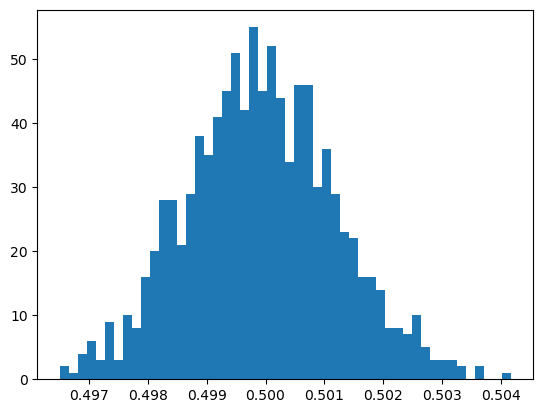

In [ ]:
plt.hist(auc_results, bins=50)
threshold = np.percentile(auc_results, 95)
plt.axvline(threshold, color='r')
plt.title("Null AUC Distribution")
plt.show()

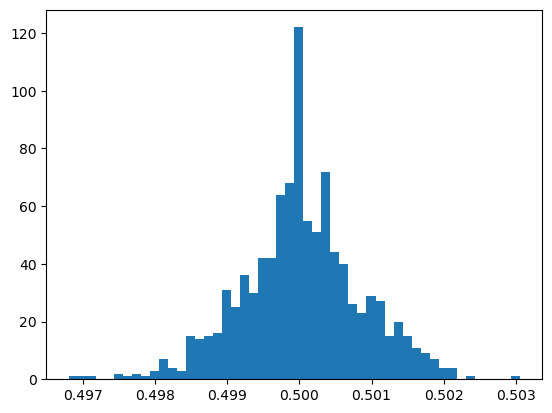

In [ ]:
plt.hist(mce_results, bins=50)
threshold = np.percentile(mce_results, 5)
plt.axvline(threshold, color='r')
plt.title("Null MCE Distribution")
plt.show()

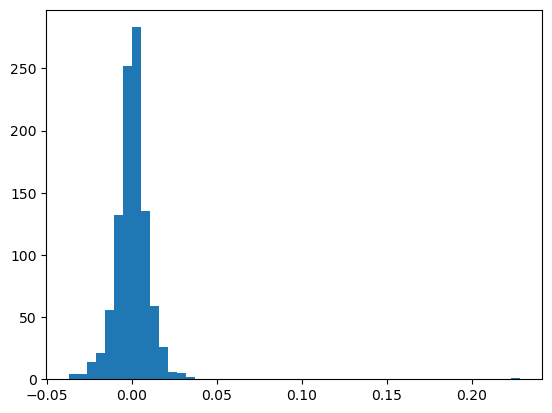

In [ ]:
plt.hist(lrt_results, bins=50)
threshold = np.percentile(lrt_results, 95)
plt.axvline(threshold, color='r')
plt.title("Null LRT Distribution")
plt.show()

In [ ]:
# Find threshold for 95% confidence level
lrt_threshold = np.percentile(lrt_results, 95)
print(lrt_threshold)

# Find threshold for 95% confidence level
mce_threshold = np.percentile(mce_results, 5)
print(mce_threshold)

# Find threshold for 95% confidence level
auc_threshold = np.percentile(auc_results, 95)
print(auc_threshold)

0.014935994047104325
0.49864400000000003
0.502029691985


In [34]:
import toml
toml_file = '../config.toml'
with open(toml_file, 'r') as f:
    config = toml.load(f)
 
config['threshold']['lrt'] = float(lrt_threshold)
config['threshold']['mce'] = float(mce_threshold)
config['threshold']['auc'] = float(auc_threshold)
with open(toml_file, 'w') as f:
    toml.dump(config, f)